In [1]:
import numpy as np
import pandas as pd

### Data load

In [290]:
merchants_train = pd.read_csv('data/merchants_train.csv', sep=';')
merchants_test = pd.read_csv('data/merchants_test.csv', sep=';')
transactions = pd.read_csv('data/transactions.csv')

In [258]:
transactions.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_date
0,178,0.000000,0.000000,9:34:47,9:30:36
1,178,55.055995,82.912991,17:49:50,17:54:24
2,178,0.000000,0.000000,9:34:47,9:31:22
3,178,55.056034,82.912734,17:49:50,17:43:01
4,178,55.056034,82.912734,17:49:50,17:45:17


In [291]:
transactions = transactions[(np.abs(transactions.latitude) > 5)]

In [260]:
transactions.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_date
1,178,55.055995,82.912991,17:49:50,17:54:24
3,178,55.056034,82.912734,17:49:50,17:43:01
4,178,55.056034,82.912734,17:49:50,17:45:17
7,178,55.055995,82.912991,17:49:50,17:51:34
8,267,55.741642,37.502628,15:34:28,15:32:51


### Control

In [261]:
from scipy.stats import mode

In [262]:
from sklearn.model_selection import KFold

In [263]:
def accuracy(data_true, data_pred):
    k = 0
    for dt, dp in zip(data_true, data_pred):
        if dp[0] != dt[0]:
            print('Check indexes!')
            return
        
        if abs(dt[1] - dp[1]) <= 0.002 and\
            abs(dt[2] - dp[2]) <= 0.002:
            k += 1
            
    return 1.0 * k / data_true.shape[0], k

In [287]:
data = merchants_train.values
kf = KFold()
train_idx, test_idx = next(kf.split(data))
train = data[train_idx]
test = data[test_idx]

In [288]:
lats = []
lons = []
k = 0
test_pred = np.empty_like(test)
for i in range(test.shape[0]):
    id_ = test[i, 0]
    tmp = transactions[transactions.merchant_id == id_]
    test_pred[i, 0] = id_
    k += 1
    if tmp.shape[0] == 0:  # if we removed zeros
        test_pred[i, 1] = 0.0
        test_pred[i, 2] = 0.0
        
        lats += [0]
        lons += [0]
    else:
        dat = tmp.longitude.values
        center = len(dat) // 2
        med_i = np.argsort(dat)[center]
        
        lat = tmp.latitude.values[med_i]
        lon = tmp.longitude.values[med_i]

        test_pred[i, 1] = lat
        test_pred[i, 2] = lon

In [289]:
accuracy(test, test_pred)

(0.12170291531698288, 263)

In [283]:
accuracy(test, test_pred)

(0.12216566404442387, 264)

In [266]:
accuracy(test, test_pred)

(0.12124016658954188, 262)

In [233]:
(abs(test_pred[:, 1] - test[:, 1]) < 0.002).sum() / test.shape[0]

0.20962517353077278

In [234]:
(abs(test_pred[:, 2] - test[:, 2]) < 0.002).sum() / test.shape[0]

0.17353077279037482

In [203]:
import matplotlib.pyplot as plt

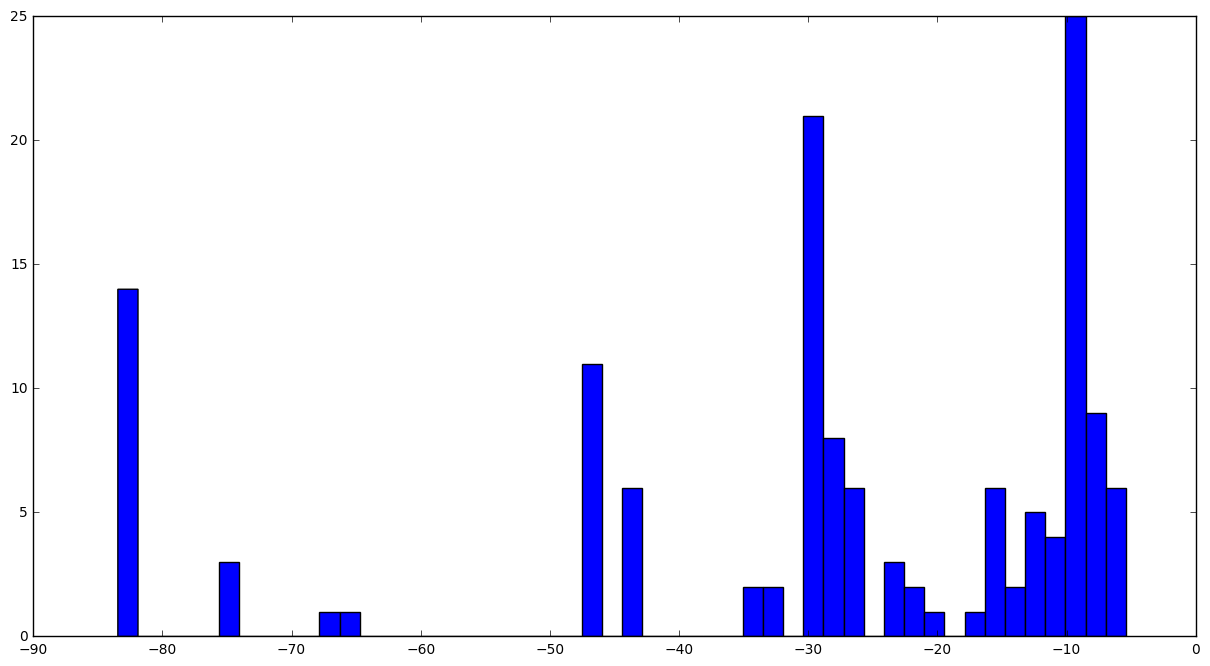

In [278]:
lats = transactions.latitude.values
lons = transactions.longitude.values
plt.figure(figsize=(15, 8))
plt.hist(lats[lats < -5], bins=50)
# plt.ylim((0, 5000))
plt.show()

### Test prediction

In [292]:
ids = []
lons = []
lats = []

In [293]:
for i, merchant_id in enumerate(merchants_test.merchant_id):
    tmp = transactions[transactions.merchant_id == merchant_id]
    ids += [merchant_id]
    if tmp.shape[0] == 0:
        lats += [0.0]
        lons += [0.0]
    else:
        dat = tmp.longitude.values
        med_i = np.argsort(dat)[len(dat) // 2]
        
        lat = tmp.latitude.values[med_i]
        lon = tmp.longitude.values[med_i]
        
        lats += [lat]
        lons += [lon]

In [9]:
merchants_test.head()

,merchant_id,latitude,longitude
0,361,NaN,NaN
1,428,NaN,NaN
2,490,NaN,NaN
3,1175,NaN,NaN
4,1239,NaN,NaN


In [294]:
df = pd.DataFrame(np.array([ids, lats, lons]).T, columns=merchants_test.columns)
df[['merchant_id']] = df[['merchant_id']].astype(np.int)

In [295]:
df.head()

,merchant_id,latitude,longitude
0,361,55.750347,37.623851
1,428,55.553254,37.723753
2,490,59.875699,30.361785
3,1175,55.775950,37.602035
4,1239,55.750347,37.623851


In [296]:
df.to_csv('submission.csv', index=None)